In [1]:
from astropy.table import Table, join
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from xcell.mappers.utils import get_DIR_Nz
from scipy.integrate import simpson

In [2]:
predir = "/home/damonge/Science/Datasets/GAIA"
gmag = 'G20.5'
cat = Table.read(f"{predir}/catalog_{gmag}.fits", format='fits')
zcat = Table.read(f"{predir}/redshifts_spz_labeled_kNN_K27_std.fits", format='fits')
zmatch = join(zcat, cat, keys=['source_id', 'phot_g_mean_mag', 'redshift_spz'])
numz = 60
zmax = 4.8
zcut = 1.46976876
zcut_hi = zmax
njk = 100

N(z) calculator via stacking

In [3]:
def get_nz_stack(cat):
    zm = cat['redshift_spz']
    zs = np.linspace(0., zmax, numz+1)
    zmid = 0.5*(zs[1:]+zs[:-1])
    sz = cat['redshift_spz_err']
    nz = np.array([np.sum(np.exp(-0.5*((z-zm)/sz)**2)/sz)
                   for z in zmid])

    return zs, nz

Calculates N(z) via p(z) stacking, DIR (using xcell), and through a simple histogram.

In [4]:
def get_nzs(cp, cs):
    # Histogram
    dndz_h, zz_h = np.histogram(cp['redshift_spz'], range=[0, zmax], bins=numz, density=True)

    # DIR estimate
    zz_dir, dndz_dir, dndz_jk, w = get_DIR_Nz(cat_spec=cs, cat_photo=cp, get_weights=True,
                                              bands=['phot_g_mean_mag', 'phot_bp_mean_mag',
                                                     'phot_rp_mean_mag',
                                                     'mag_w1_vg', 'mag_w2_vg'],
                                              zflag='z_sdss', nz=numz, zrange=[0, zmax], njk=njk)
    e_dndz_dir = np.std(dndz_jk, axis=0)*np.sqrt((njk-1)**2/njk)
    norm = simpson(dndz_dir, x=zz_dir[:-1])
    dndz_dir /= norm
    e_dndz_dir /= norm

    # PDF stack
    zz_G, dndz_G = get_nz_stack(cp)
    dndz_G /= simpson(dndz_G, x=zz_G[:-1])

    assert np.allclose(zz_h, zz_dir, atol=0, rtol=1E-3)
    assert np.allclose(zz_h, zz_G, atol=0, rtol=1E-3)
    return zz_h, dndz_h, dndz_dir, e_dndz_dir, dndz_G, w

Calculate for the full catalog and for each redhshift bin

In [5]:
c = cat[cat['redshift_spz'] <= zcut_hi]
s = zmatch[zmatch['redshift_spz'] <= zcut_hi]
z_tot, dndz_h_tot, dndz_dir_tot, e_dndz_dir_tot, dndz_G_tot, w_tot = get_nzs(c, s)

In [6]:
c = cat[cat['redshift_spz'] < zcut]
s = zmatch[zmatch['redshift_spz'] < zcut]
z_lo, dndz_h_lo, dndz_dir_lo, e_dndz_dir_lo, dndz_G_lo, _ = get_nzs(c, s)

In [7]:
c = cat[(cat['redshift_spz'] >= zcut) & (cat['redshift_spz'] <= zcut_hi)]
s = zmatch[(zmatch['redshift_spz'] >= zcut) & (zmatch['redshift_spz'] <= zcut_hi)]
z_hi, dndz_h_hi, dndz_dir_hi, e_dndz_dir_hi, dndz_G_hi, _ = get_nzs(c, s)

Plot result

Text(0, 0.5, 'dp/dz')

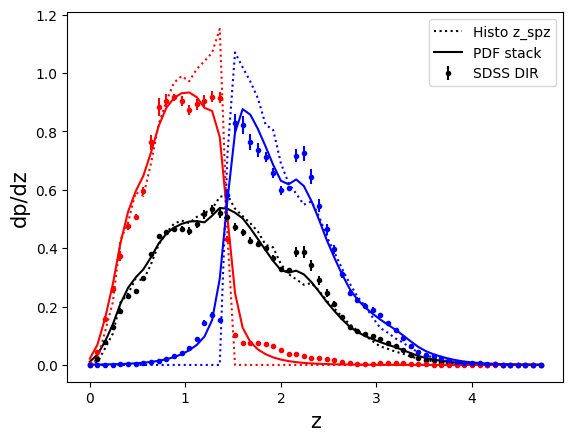

In [8]:
plt.plot(z_tot[:-1], dndz_h_tot, 'k:', label='Histo z_spz')
plt.plot(z_tot[:-1], dndz_G_tot, 'k-', label='PDF stack')
plt.errorbar(z_tot[:-1], dndz_dir_tot, yerr=e_dndz_dir_tot, fmt='k.', label='SDSS DIR')
plt.plot(z_lo[:-1], dndz_h_lo, 'r:')
plt.plot(z_lo[:-1], dndz_G_lo, 'r-')
plt.errorbar(z_lo[:-1], dndz_dir_lo, yerr=e_dndz_dir_lo, fmt='r.')
plt.plot(z_hi[:-1], dndz_h_hi, 'b:')
plt.plot(z_hi[:-1], dndz_G_hi, 'b-')
plt.errorbar(z_hi[:-1], dndz_dir_hi, yerr=e_dndz_dir_hi, fmt='b.')
plt.legend()
plt.xlabel('z', fontsize=15)
plt.ylabel('dp/dz', fontsize=15)

Save to file

In [9]:
suff = ''
if zmax != zcut_hi:
    suff = '_zcuthi'
np.savez(f'dndzs_{gmag}_1bins_bin1.npz', z=z_tot,
         pz_h=dndz_h_tot, pz_G=dndz_G_tot,
         pz_dir=dndz_dir_tot, err_dir=e_dndz_dir_tot)
np.savez(f'dndzs_{gmag}_2bins_bin1.npz', z=z_lo,
         pz_h=dndz_h_lo, pz_G=dndz_G_lo,
         pz_dir=dndz_dir_lo, err_dir=e_dndz_dir_lo)
np.savez(f'dndzs_{gmag}_2bins_bin2{suff}.npz', z=z_hi,
         pz_h=dndz_h_hi, pz_G=dndz_G_hi,
         pz_dir=dndz_dir_hi, err_dir=e_dndz_dir_hi)

Now check that the reweighted SDSS catalog has the same flux distribution as QUaia

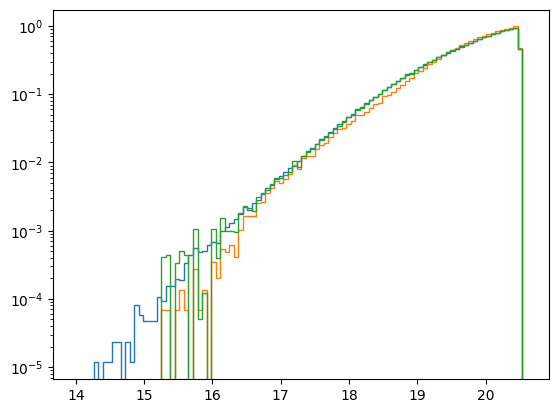

In [10]:
plt.hist(cat['phot_g_mean_mag'], range=[14, 20.6], bins=100, log=True, density=True, histtype='step')
plt.hist(zmatch['phot_g_mean_mag'], range=[14, 20.6], bins=100, log=True, density=True, histtype='step');
plt.hist(zmatch['phot_g_mean_mag'], weights=w_tot, range=[14, 20.6], bins=100, log=True, density=True, histtype='step');

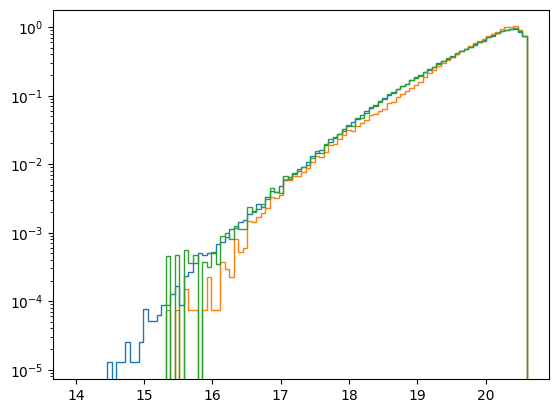

In [11]:
plt.hist(cat['phot_bp_mean_mag'], range=[14, 20.6], bins=100, log=True, density=True, histtype='step')
plt.hist(zmatch['phot_bp_mean_mag'], range=[14, 20.6], bins=100, log=True, density=True, histtype='step');
plt.hist(zmatch['phot_bp_mean_mag'], weights=w_tot, range=[14, 20.6], bins=100, log=True, density=True, histtype='step');

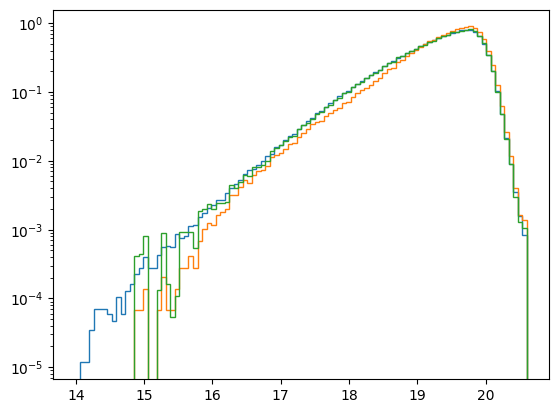

In [12]:
plt.hist(cat['phot_rp_mean_mag'], range=[14, 20.6], bins=100, log=True, density=True, histtype='step')
plt.hist(zmatch['phot_rp_mean_mag'], range=[14, 20.6], bins=100, log=True, density=True, histtype='step');
plt.hist(zmatch['phot_rp_mean_mag'], weights=w_tot, range=[14, 20.6], bins=100, log=True, density=True, histtype='step');

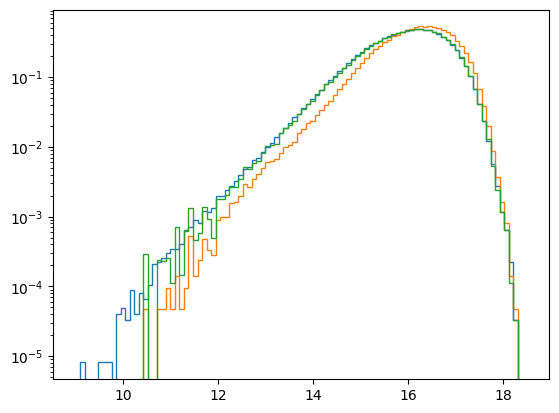

In [13]:
plt.hist(cat['mag_w1_vg'], range=[9, 18.5], bins=100, log=True, density=True, histtype='step')
plt.hist(zmatch['mag_w1_vg'], range=[9, 18.5], bins=100, log=True, density=True, histtype='step');
plt.hist(zmatch['mag_w1_vg'], weights=w_tot, range=[9, 18.5], bins=100, log=True, density=True, histtype='step');

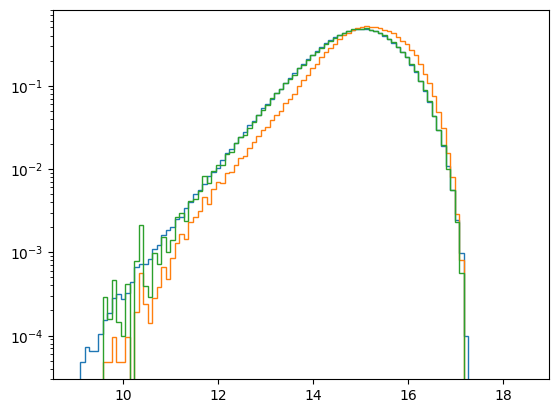

In [14]:
plt.hist(cat['mag_w2_vg'], range=[9, 18.5], bins=100, log=True, density=True, histtype='step')
plt.hist(zmatch['mag_w2_vg'], range=[9, 18.5], bins=100, log=True, density=True, histtype='step');
plt.hist(zmatch['mag_w2_vg'], weights=w_tot, range=[9, 18.5], bins=100, log=True, density=True, histtype='step');